In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import constants 
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

import seaborn as sns
import itertools
from compute_alpha_hour import compute_alpha_hour
from joblib import load
from joblib import dump
import datetime

import scienceplots
plt.style.use(['science','nature','no-latex','vibrant'])




#Import personal functions
import sys
#sys.path.append("C:/Users/Olivi/OneDrive - TU Eindhoven/Soft robotic matter/GitHub/Thermal_Soft_Robotics/Functions")
sys.path.append("//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Functions")
from save_plot_func import save_plot
from pathlib import Path


In [11]:
# Load weather data 

# Define the network location and the rest of the path components
network_location = r"\\sun\overvelde"
path_components = ["group-folder", "PROJECTS", "Thermal_soft_robotics_Olivier", "Git", "Thermal_Soft_Robotics", "Thermal_actuation", "Model", "Pressure_vessel", "Meteo_data"]
folder = "Weather_data_2023_7_8_n1.csv"

# Combine the network location and path components into a Path object
file_path = Path(network_location, *path_components,folder)
print(file_path)

# specify the file path (use the actual path on your system)
#file_path = 'Meteo_data/Weather_data_2023_7_8_n1'

# read the CSV file into a DataFrame
df = pd.read_csv(file_path) #Data in seconds, T in K and P in Pa, windspeed in m/s, 0.1 meter above the ground

# Set time period
n_days = int(str(folder[-5])) #Extract how many days are simulated in the file
df

\\sun\overvelde\group-folder\PROJECTS\Thermal_soft_robotics_Olivier\Git\Thermal_Soft_Robotics\Thermal_actuation\Model\Pressure_vessel\Meteo_data\Weather_data_2023_7_8_n1.csv


,t,T_amb,P_amb,v_wind,P_sun
0,0.0,292.200000,101790.000000,1.141151,0.0
1,1.0,292.199833,101789.988889,1.141151,0.0
2,2.0,292.199667,101789.977778,1.141151,0.0
3,3.0,292.199500,101789.966667,1.141151,0.0
4,4.0,292.199333,101789.955556,1.141151,0.0
...,...,...,...,...,...
86396,86396.0,296.400000,101710.000000,1.033567,0.0
86397,86397.0,296.400000,101710.000000,1.033567,0.0
86398,86398.0,296.400000,101710.000000,1.033567,0.0
86399,86399.0,296.400000,101710.000000,1.033567,0.0


In [12]:
smoothing_factor=1
t=range(len(df['t']))
T_amb_spline = UnivariateSpline(df['t'], df['T_amb'], s=smoothing_factor)
P_amb_spline = UnivariateSpline(df['t'], df['P_amb'], s=smoothing_factor)
P_sun_spline = UnivariateSpline(df['t'], df['P_sun'], s=smoothing_factor)

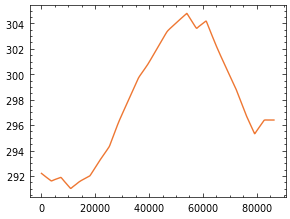

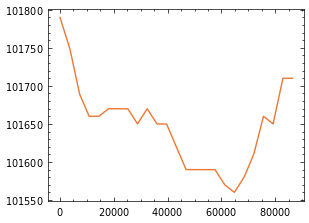

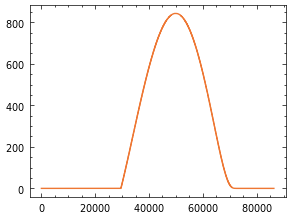

In [13]:
plt.plot(t,T_amb_spline(t))
plt.show()
plt.plot(t,P_amb_spline(t))
plt.show()
plt.plot(t,P_sun_spline(t))
plt.show()

In [ ]:
%whos

Variable             Type                Data/Info
--------------------------------------------------
CubicSpline          type                <class 'scipy.interpolate._cubic.CubicSpline'>
P_amb_spline         UnivariateSpline    <scipy.interpolate._fitpa<...>ct at 0x000001B7C77E7110>
P_sun_spline         UnivariateSpline    <scipy.interpolate._fitpa<...>ct at 0x000001B7C77E72D0>
T_amb_spline         UnivariateSpline    <scipy.interpolate._fitpa<...>ct at 0x000001B7C77E7010>
UnivariateSpline     type                <class 'scipy.interpolate<...>tpack2.UnivariateSpline'>
compute_alpha_hour   function            <function compute_alpha_h<...>ur at 0x000001B7C656C720>
constants            module              <module 'scipy.constants'<...>\constants\\__init__.py'>
datetime             module              <module 'datetime' from '<...>ra8p0\\Lib\\datetime.py'>
df                   DataFrame                               t    <...>[432005 rows x 5 columns]
dump                 function     

Simulation variables

In [14]:
#Vessel variables
#rho_vessel = 2.7e3 # aluminium [kg/m3]
rho_vessel = 1.455e3 # Pet [kg/m3] Source: https://plasticranger.com/density-of-pet-plastic/#:~:text=The%20density%20of%20PET%20plastic%20is%201.38%20g%2Fcm%C2%B3%20and,(1.2%20g%2Fcm3).
t_vessel = 0.5e-3 # Thickness [m]
#c_vessel = 890 #J/kg aluminium
c_vessel = 1030 #J/kg Pet Source: https://www.engineeringtoolbox.com/specific-heat-polymers-d_1862.html

#Assumptions
A_factor=0.5 #Assume half of the area of the vessel is exposed to sunlight 
e = 0.9 # emissvity factor black epoxy
alpha=100#[W/M^2K] Convection heat transfer coeficient
P_crit=1e3 #[pa] critical pressure where the hysterical valve opens
cloud_factor = np.linspace(0.1,1,2) # 1 = sunny, 0 = dark 


Simulation constants

In [15]:
#Vessel properties 
D = np.linspace(0.05,0.3,2) #Diameter vessel
L = np.linspace(0.05,0.3,2) #Lenght vessel

# Create a 2-D grid for D and L
D, L = np.meshgrid(D, L)

# Now D and L are 2-D arrays containing all combinations of diameter and length
V = D**2/4*np.pi*L  # [m^3]
A = D*L + D**2/4*np.pi  # [m^2]

#Air 
rho_air=1.293 #kgm-3 
m_air = rho_air*V #[kg]
R = constants.R #J/K*molz ideal gas constant 
c_air = 718 #j/kg K constant volume
n_mass = 28.96747 #molar mass [g/mol]
n = m_air/n_mass #Amount of mol air 
sigma = constants.sigma #Boltzman constant 

cp = 1000 #J/kgK @ 300 K
cv = 718 #J/kgK @ 300k
y = cp/cv 
K = 273.15 #Kelvin 

#Combined properties
m_vessel = A*t_vessel*rho_vessel
m = m_vessel+m_air #kg
c = m_vessel/m*c_vessel+m_air/m*c_air #j/kg K 

# Find the dimensions of A_exposed
num_rows, num_cols = A.shape
A_exposed= A_factor*A

# Create an array for each hour in the day, converted to seconds
dt=1 # Second
day_length = n_days*24 * 60 * 60  # length of a day in seconds
time_steps = np.linspace(0, day_length, num=day_length // dt + n_days)  # time steps
hours = np.arange(n_days*24)*60*60


Heat transfer coefficient alpha as function of windspeed and cilinder diameter

In [16]:
#Interpolate the hourly wind data to convection per second
alpha_hour = compute_alpha_hour(num_rows, num_cols, D, df['v_wind'], time_steps, hours)

Define system of ODE's

In [26]:
def system(t, y, params):
    T, P, n_mol = y
    
    P_amb, solar_constants, A_Exposed, cloud_factor, T_amb,R, m, c,boiling_point, latent_heat, liquid_molar_mass, current_liquid_mass, current_vapor_mass, ii, jj, ff= params
    
    

    P_sun = P_sun_spline(t) * A_Exposed[ii, jj] * cloud_factor[ff] *dt
    interpolated_P_amb = P_amb_spline(t)    
    interpolated_T_amb = T_amb_spline(t)
    Q_rad = e * sigma * A_exposed[ii,jj] * (T**4 - interpolated_T_amb**4)
    
    #Interpolate alpha from hours to seconds
    alpha_interpolated_func = interp1d(np.arange(len(T_amb)), alpha_hour[ii,jj,:], bounds_error=False, fill_value="extrapolate")
    interpolated_alpha = alpha_interpolated_func(t)
    Q_con = interpolated_alpha * A_exposed[ii,jj] * (T - interpolated_T_amb)

    if T >= boiling_point and current_liquid_mass >0:
        # Determine the amount of heat available for evaporation
        heat_for_evaporation = P_sun - Q_rad - Q_con  # Assuming this is the available heat

        # Calculate the rate of evaporation (mass per unit time)
        evaporation_rate = min(heat_for_evaporation / latent_heat, initial_liquid_mass / dt)

        # Update the amount of liquid
        initial_liquid_mass -= evaporation_rate * dt

        # Convert evaporated mass to moles and add to the gas in the vessel
        evaporated_moles = evaporation_rate / liquid_molar_mass
        n_mol += evaporated_moles

    elif T < boiling_point and current_vapor_mass > 0:
        # You can define a condensation rate based on your system's specifics
        heat_for_condensation = P_sun - Q_rad - Q_con 
        condensation_rate = min(heat_for_condensation / latent_heat, initial_liquid_mass / dt)

        # Update liquid and vapor masses
        current_vapor_mass -= condensation_rate * dt
        current_liquid_mass += condensation_rate * dt

        # Convert condensed vapor to moles and subtract from gas in the vessel
        condensed_moles = condensation_rate / liquid_molar_mass
        n_mol -= condensed_moles

    
    #Compute pressure change in vessel due to temperature increase
    dT_dt = (P_sun-Q_rad-Q_con) / (m[ii, jj] * c[ii, jj])
    dP_dt = (n_mol*R*dT_dt)/V[ii,jj]    
    dn_dt = 0
    return [dT_dt, dP_dt,dn_dt]

boiling_point =34+273 # K
latent_heat = 142e3 # j/kg
current_liquid_mass = 10e-3 # kg
liquid_molar_mass=200e-3 # kf
current_vapor_mass = 0

#Define simulation settings
t_span = [0, len(df['P_sun'].values)]  # start and end time
current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S') #Define current time for saving

params_base = [df['P_amb'].values,df['P_sun'].values,A_exposed, cloud_factor,df['T_amb'].values, R,m, c ,boiling_point, latent_heat, liquid_molar_mass, current_liquid_mass, current_vapor_mass]

# Use itertools.product to simplify nested loops

for ii, jj, ff in itertools.product(range(len(D)), range(len(L)), range(len(cloud_factor))):
    ii=jj=1
    params = params_base + [ii, jj, ff]
    print(ii,jj,ff)
    
    # Define initial conditions
    n0 = df['P_amb'][0]*V[ii,jj]/(R*df['T_amb'][0])
    y0 = [df['T_amb'][0], df['P_amb'][0], n0]
    
    t_start= t_span[0]
    nsampling = int(1*t_span[1])
    
    print(y0,t_start)
    sol = solve_ivp(system, [t_start, t_span[1]], y0, dense_output=True, args=(params,),method='RK45',
            t_eval=np.linspace(t_start,t_span[1],n_days*24*3600), rtol=1e-5, atol=1e-7)
      
    print(sol.message)
    t= sol.t
    y= sol.y   
    #dump(sol,f"..\\Saved_solutions\wo_valve_novec7000{file_path[-15:-4]}_{current_time}_{ii}_{jj}_{ff}_sol.joblib")
    
    break

 



1 1 0
[292.2, 101790.0, 0.888473263424082] 0
1 1 0
P_sun_spline -1.542058824022102e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -0.14006145469780498
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -1.541989571286442e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -1.5419549453831737e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -1.5417818205123975e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -1.5417510435681722e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -1.541712572732e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -1.541712572732e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -1.5410201630602614e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline -1.5406740046764775e-08
A_exposed 0.08034291735288518
cloud_factor 0.1
dt 1
1 1 0
P_sun_spline

UnboundLocalError: cannot access local variable 'initial_liquid_mass' where it is not associated with a value

In [23]:
A_exposed[ii,jj]

0.08034291735288518

In [ ]:
import os
from joblib import dump  # Make sure to import dump if you haven't already

# Create 'Saved_solutions' directory if it doesn't exist
directory = "..\\Saved_solutions\\"
if not os.path.exists(directory):
    os.makedirs(directory)

# Generate the file name and full path
file_name = f"wo_valve_{file_path[-15:-4]}_{current_time}_{ii}_{jj}_{ff}_sol.joblib"
full_path = os.path.join(directory, file_name)

# Try to dump the solution object to the specified path
try:
    dump(sol, full_path)
    print(f"Solution object dumped successfully to {full_path}")
except FileNotFoundError:
    print(f"Could not write to {full_path}")

Solution object dumped successfully to ..\Saved_solutions\wo_valve_2023_7_6_n5_20231004_195746_0_0_0_sol.joblib


In [ ]:
#Load old solution
#sol = load('..\\Saved_solutions\sol.joblib')
#t=sol.t
#y=sol.y

In [ ]:
#Set necesarry variables for plotting
#ii=jj=ff=0
#P_open=2e3
#P_close =1e3

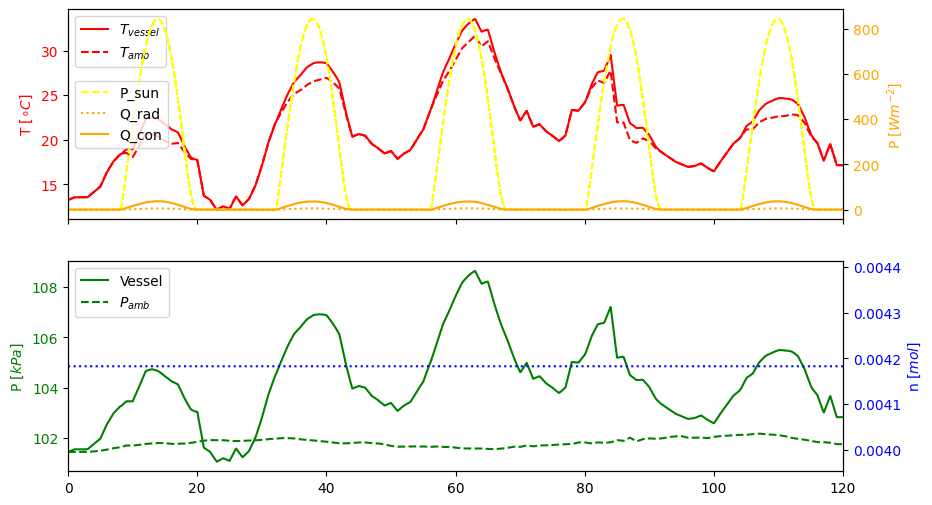

In [ ]:
# Calculate solar constants
#t = np.linspace(0, len(df['P_sun'].values), len(df['P_sun'].values))
solar_constants_func = interp1d(np.arange(len(df['P_sun'].values)), df['P_sun'].values, bounds_error=False, fill_value="extrapolate")
interpolated_solar_constants = solar_constants_func(t)

def interpolate_data(T, t, A_exposed, alpha_hour, T_amb,P_amb, ii, jj):
    # Interpolate T_amb
    #T_amb_func = interp1d(np.arange(len(T_amb)), T_amb, bounds_error=False, fill_value="extrapolate")
    #interpolated_T_amb = T_amb_func(t)
    interpolated_T_amb=T_amb_spline(t)
    

    #P_amb_func = interp1d(np.arange(len(P_amb)), P_amb, bounds_error=False, fill_value="extrapolate")
    #interpolated_P_amb = P_amb_func(t)
    interpolated_P_amb = P_amb_spline(t)
    
    # Interpolate alpha_hour
    alpha_interpolated_func = interp1d(np.arange(len(T_amb)), alpha_hour[ii,jj,:], bounds_error=False, fill_value="extrapolate")
    interpolated_alpha = alpha_interpolated_func(t)
    
    Q_rad = e * sigma * A_exposed[ii,jj] * (T**4 - interpolated_T_amb**4)
    Q_con = interpolated_alpha * A_exposed[ii,jj] * (T - interpolated_T_amb)
    return Q_rad, Q_con, interpolated_P_amb,interpolated_T_amb

#Eval function
y1 = sol.sol(t)

Q_rad, Q_con,P_amb, T_amb = interpolate_data(y1[0,:], t, A_exposed, alpha_hour, df['T_amb'].values,df['P_amb'].values, ii, jj)
#n_mol = y[1,:] * V[ii,jj] / (R * y[0,:]) 
#Plot results 

fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True,figsize=(10,6))  # Create two subplots sharing the same x-axis

# First subplot for temperature and solar constants
ax2 = ax1.twinx()  # Create a second y-axis for the first subplot
ax1.plot(t/3600, y[0,:]-K,color='red',label='$T_{vessel}$') 
ax1.plot(t/3600, T_amb_spline(t)-K,color='red', linestyle='--',label='$T_{amb}$') 
ax1.legend(loc='upper left')
ax1.set_ylabel('T [$\\circ C$]',color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(t/3600, P_sun_spline(t), color='yellow',label='P_sun',linestyle='--')
ax2.plot(t/3600, Q_rad/A[ii,jj], label='Q_rad', linestyle=':', color='orange')
ax2.plot(t/3600, Q_con/A[ii,jj], label='Q_con', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylabel('P [$Wm^{-2}$]', color='orange')
ax2.legend()

# Second subplot for pressure and moles
ax4 = ax3.twinx()  # Create a second y-axis for the second subplot
ax3.plot(t/3600, y[1,:]/1000, color='green',label='Vessel') 
#ax3.plot(t/3600, y[2,:]/1000, color='red',label='Act') 
ax3.plot(t/3600, P_amb_spline(t)/1000, color='green', linestyle='--',label='$P_{amb}$')
#ax3.plot(t/3600, (y[2,:]+P_open)/1000, color='pink', linestyle='-.',label='$P_{open}$')
#ax3.plot(t/3600, (y[2,:]+P_close)/1000, color='pink', linestyle='-.',label='$P_{close}$')
#ax3.plot(t/3600, (P_amb-P_in)/1000, color='pink', linestyle='--',label='$P_{in}$')
ax3.set_ylabel('P [$kPa$]', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.legend(loc='upper left')

ax4.plot(t/3600, y[-1,:], color='blue',linestyle=':')  # Plot n_mol on the second y-axis
ax4.set_ylabel('n [$mol$]', color='blue')
ax4.tick_params(axis='y', labelcolor='blue')
#ax4.set_ylim(0,n[ii,jj]*1.1)

#ax5.plot(t/3600, y[2,:], color='green',label='P_act') 
#ax5.plot(t/3600, P_amb_spline(t), color='blue',label='P_amb') 
#ax5.set_ylim(-0.1,1.1)
#ax5.legend()
#ax5.set_xlabel('Time [$h$]')

plt.xlim(0,n_days*24)
#plt.savefig(f"..\\figures\\{file_path[-15:-4]}_{current_time}.svg", format="svg")
plt.show() 



In [ ]:
len(y[0])

432000